# Inference of parameters with latent variables (SIR model)
In this notebook, we consider the SIR model with symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

when given the full data (of classes S, Ia, Is) from a generated trajectory.

In [2]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [3]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [5]:
M  = 2          # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 1          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([20, 20])  # each age group has asymptomatic infectives
Is0 = np.array([20, 20])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('latent_SIR_traj.npy', data_array)

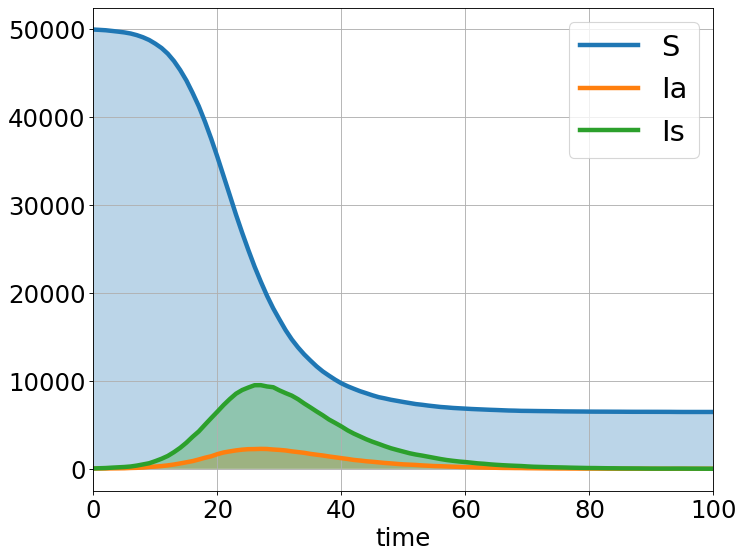

In [6]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=4)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

## 2) Inference
We take the first $20$ data points of the $I_\mathrm{s}$ trajectory and use it to infer the parameters of the model.

In [7]:
# load the data and rescale to intensive variables 
Tf_inference = 20
Nf_inference = Tf_inference + 1

x = np.load('latent_SIR_traj.npy').astype('float')
x = (x/N)[:Nf_inference]
steps = 101 # number internal integration steps taken, must be an odd number 

# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

### 2.1) Make a filter for the observed data 
We want a matrix $\boldsymbol{F}$ such that 
$$
\boldsymbol{F}\boldsymbol{x} = \boldsymbol{x}_\mathrm{obs}
$$

In [8]:
# a filter that sums over all the infected people for each age group
fltr = np.kron([0, 1, 1],np.identity(M))
print(fltr)

[[0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1.]]


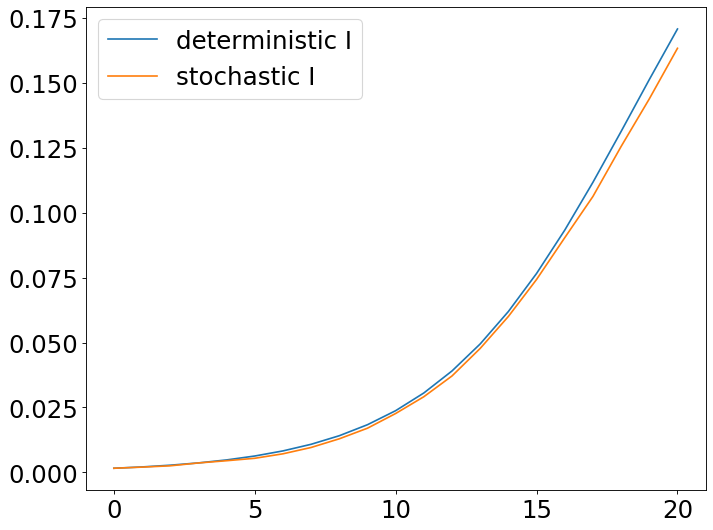

In [9]:
# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
obs=np.einsum('ij,kj->ki', fltr, x)

x0=x[0]
det_model = pyross.deterministic.SIR(parameters, int(M), fi)
xm = estimator.integrate(x[0], 0, Tf_inference, Nf_inference, det_model, contactMatrix)
det_obs = np.einsum('ij,kj->ki', fltr, xm)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(det_obs, axis=1), label='deterministic I')
plt.plot(np.sum(obs, axis=1), label='stochastic I')
plt.legend()
plt.show()

In [10]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)


end_time = time.time()
print(logp) 
print(end_time - start_time)

-263.3236077840899
0.23868489265441895


In [15]:
# make parameter guesses and set up bounds for each parameter 
eps=1e-4

alpha_g = 0.22
alpha_std = 0.05 
alpha_bounds = (eps, 1-2*eps)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.04
beta_std = 0.04 
beta_bounds = (eps, 1)

gIa_g = 0.2
gIa_std = 0.1 
gIa_bounds = (eps, 1)

gIs_g = 0.2
gIs_std = 0.1 
gIs_bounds = (eps, 1) 

# not inferred 
fsa_g = 0.8

Ia0_g = (Ia0+3)/N
Ia_std = Ia0_g*0.4 
bounds_for_Ia = np.tile([0.1/N, 100/N], M).reshape(M, 2)

S0_g = (S0-3)/N # need the sum of S0_g + I0 (observed in this case) over each age group to be larger than fi 
S_std = Ia_std*np.sqrt(3)
bounds_for_S = np.array([(0.1/N, f-1/N) for f in fi]).reshape(M, 2)

# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# set up bounds, guess and stds for the rest of the params 
keys = ['alpha', 'beta', 'gIa', 'gIs']
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, 
                   *bounds_for_S, *bounds_for_Ia])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, *S0_g, *Ia0_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, *S_std, *Ia_std])

# set up fltr for initial conditions because they are constraint by the observed 
init_fltr = np.repeat([True, True, False], M)

start_time = time.time()
params = estimator.latent_infer_parameters(keys, init_fltr, guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                    global_max_iter=10, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 8 (seed=3282484151, Mon May 18 18:34:21 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -2.964674900424683e+02 1.0e+00 8.77e-01  2e-04  9e-02 0:03.2
    2     32 -2.087263371593614e+02 1.3e+00 8.38e-01  1e-04  8e-02 0:05.2


/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [2] are not finite but [inf]. (class=CMAEvolutionStrategy method=ask iteration=1)
  ')')


    3     48 -2.612647577973288e+02 1.4e+00 8.17e-01  1e-04  8e-02 0:08.1


/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [3] are not finite but [inf]. (class=CMAEvolutionStrategy method=ask iteration=3)
  ')')


    5     80 -2.503246759225867e+02 1.7e+00 6.37e-01  1e-04  6e-02 0:13.1
    7    112 -2.590035811645445e+02 2.0e+00 6.70e-01  1e-04  7e-02 0:18.2
   10    160 -2.979873393838482e+02 3.4e+00 6.35e-01  1e-04  7e-02 0:25.7
Optimal value (global minimisation):  -297.98733938384817
Starting local minimisation...
Optimal value (local minimisation):  -298.4550467604124
486.45556116104126


In [16]:
# save the parameters 
np.save('SIR_latent_param.npy', params)

In [17]:
# print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
print(parameters)

params = np.load('SIR_latent_param.npy')
best_estimates = estimator.fill_params_dict(keys, params)
print('\n Best estimates')
print(best_estimates)

print('\n True initial conditions: ') 
print(S0, Ia0, Is0)

partial_inits = params[len(keys):]
x0 = estimator.fill_initial_conditions(partial_inits, obs[0], init_fltr, fltr)
print('\n Inferred initial conditons: ') 
print((x0*N).astype('int'))

True parameters
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 1}

 Best estimates
{'alpha': 0.1831419379830624, 'beta': 0.02108312704365709, 'gIa': 0.1998914210058047, 'gIs': 0.1553072440614498, 'fsa': 1}

 True initial conditions: 
[12460. 37460.] [20 20] [20 20]

 Inferred initial conditons: 
[12457 37455    20    17    19    22]


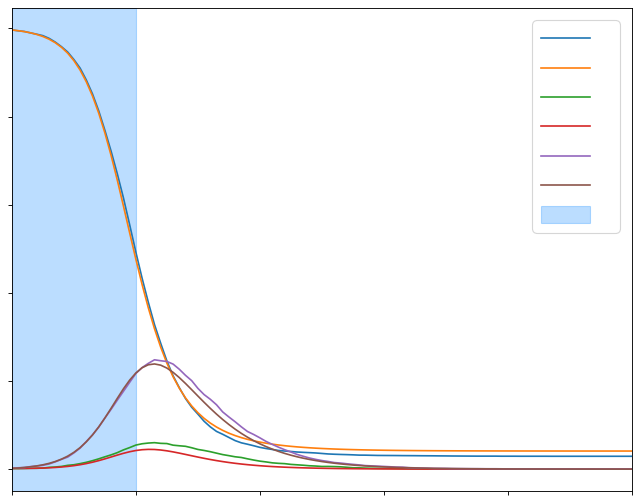

In [18]:
# plot the guessed trajectory and the true trajectory 
estimator.set_params(best_estimates)
det_model = pyross.deterministic.SIR(best_estimates, int(M), fi)
partial_inits = params[len(keys):]
x0 = estimator.fill_initial_conditions(partial_inits, obs[0], init_fltr, fltr)
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x = np.load('latent_SIR_traj.npy').astype('float')/N 
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(x[:,0], label='True S')
plt.plot(x_det[:, 0], label='Inferred S')
plt.plot(x[:,1*M], label='True Ia')
plt.plot(x_det[:, 1*M], label='Inferred Ia')
plt.plot(x[:,2*M], label='True Is')
plt.plot(x_det[:, 2*M], label='Inferred Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend()
plt.show()

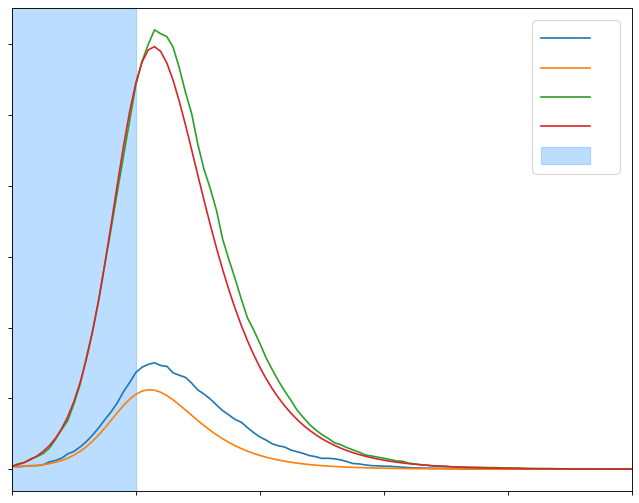

In [19]:
# replot the infected 
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(x[:,1*M], label='True Ia')
plt.plot(x_det[:, 1*M], label='Inferred Ia')
plt.plot(x[:,2*M], label='True Is')
plt.plot(x_det[:, 2*M], label='Inferred Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend()
plt.show()

### Next step (working progress): sample the parameters with nested sampling to get a better prediction. 